### Bitcoin EDA and Stochastic Sim

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

In [21]:
os.chdir('C:/Users/gerar/OneDrive/Documentos/GitHub/bitcoinPred')  # Set the working directory

def load_data(file_path="data/processed/btc_data_processed.csv"):
    """Load the dataset into a pandas DataFrame."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} was not found. Run fetch_data.py first.")
    
    df = pd.read_csv(file_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])  # Convert timestamps
    return df

def inspect_data(df):
    """Print basic info and statistics."""
    print("First 5 rows:\n", df.head(), "\n")
    print("Data Summary:\n", df.info(), "\n")
    print("Descriptive Statistics:\n", df.describe(), "\n")
    print("Missing Values:\n", df.isnull().sum(), "\n")

if __name__ == "__main__":
    df = load_data()
    inspect_data(df)

First 5 rows:
    timestamp     open     high      low    close       volume     close_time  \
0 2017-09-16  3674.01  3950.00  3470.66  3714.95  1297.563953  1505606399999   
1 2017-09-17  3685.23  3748.21  3499.02  3699.99   682.171210  1505692799999   
2 2017-09-18  3690.00  4123.20  3690.00  4035.01  1030.006455  1505779199999   
3 2017-09-19  4060.00  4089.97  3830.91  3910.04   902.332129  1505865599999   
4 2017-09-20  3910.04  4046.08  3820.00  3900.00   720.935076  1505951999999   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0        4.804878e+06              8809                   624.887842   
1        2.466490e+06              6355                   273.931976   
2        4.069033e+06              8220                   417.638722   
3        3.558315e+06              7342                   257.320352   
4        2.839584e+06              7231                   395.275138   

   taker_buy_quote_asset_volume   returns  moving_avg_7  moving_avg_30 

### Trading Volume

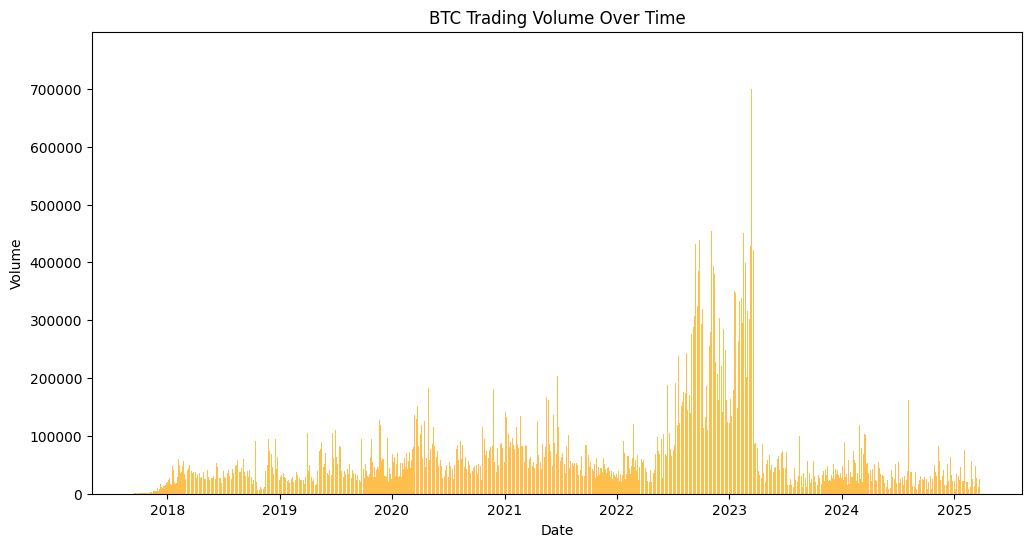

In [22]:
def plot_trading_volume(df):
    """Plot trading volume over time."""
    plt.figure(figsize=(12, 6))
    plt.bar(df["timestamp"], df["volume"], color="orange", alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.title("BTC Trading Volume Over Time")
    plt.show()

if __name__ == "__main__":
    df = load_data()
    plot_trading_volume(df)

### Returns

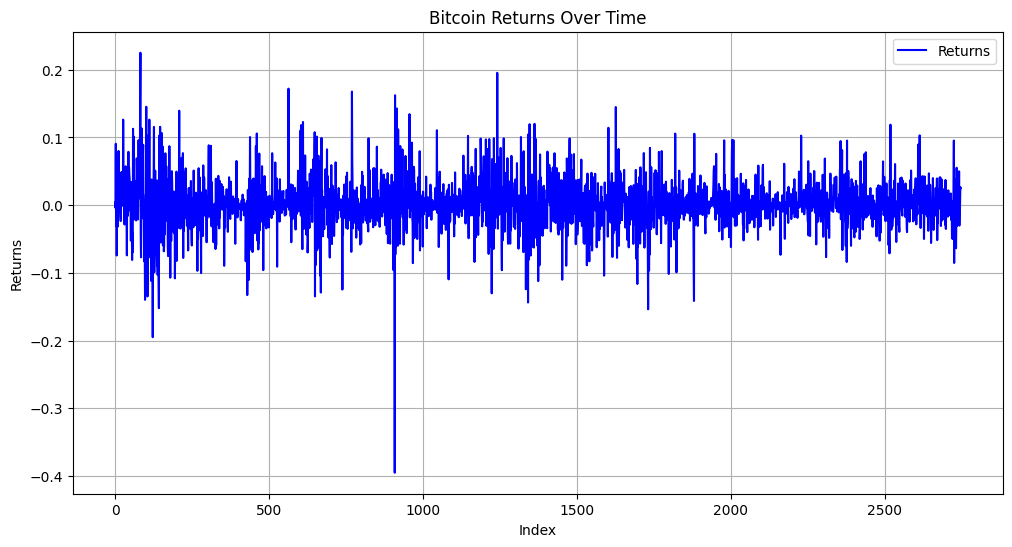

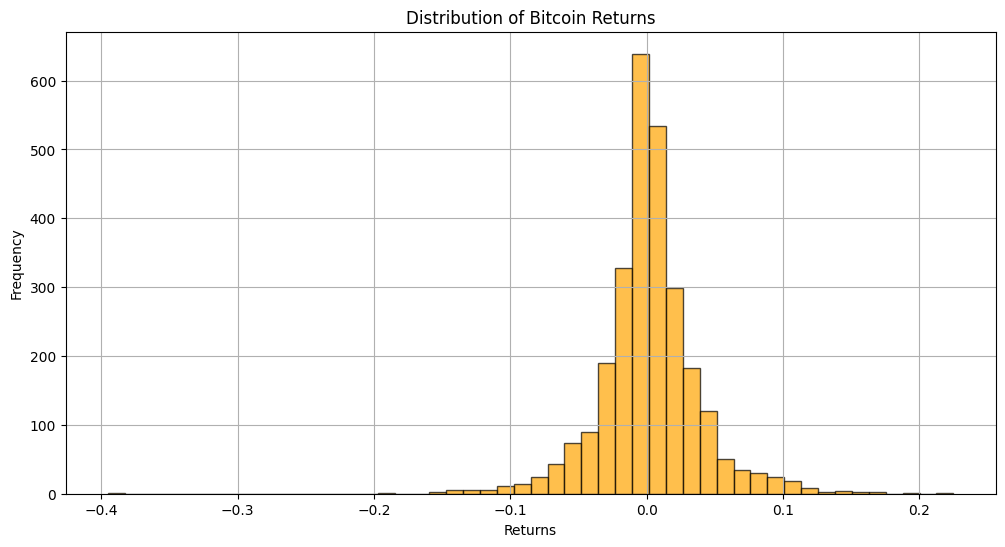

In [23]:


# Ensure the 'returns' column exists
if 'returns' in df.columns:
    # Plot the 'returns' column as a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['returns'], label='Returns', color='blue')
    plt.title('Bitcoin Returns Over Time')
    plt.xlabel('Index')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the distribution of returns as a histogram
    plt.figure(figsize=(12, 6))
    plt.hist(df['returns'], bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Bitcoin Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
else:
    print("The 'returns' column does not exist in the dataset.")

### MAs and Volatility

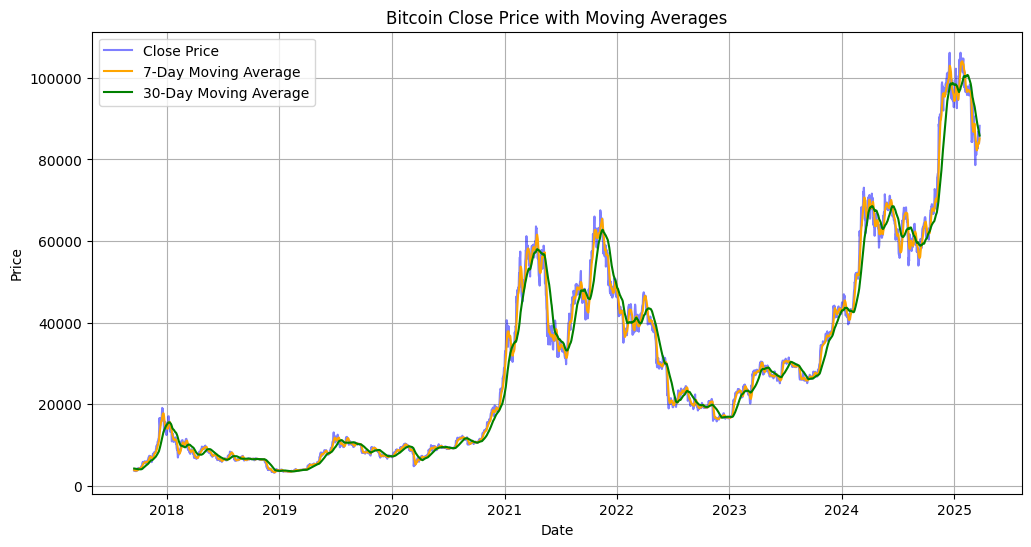

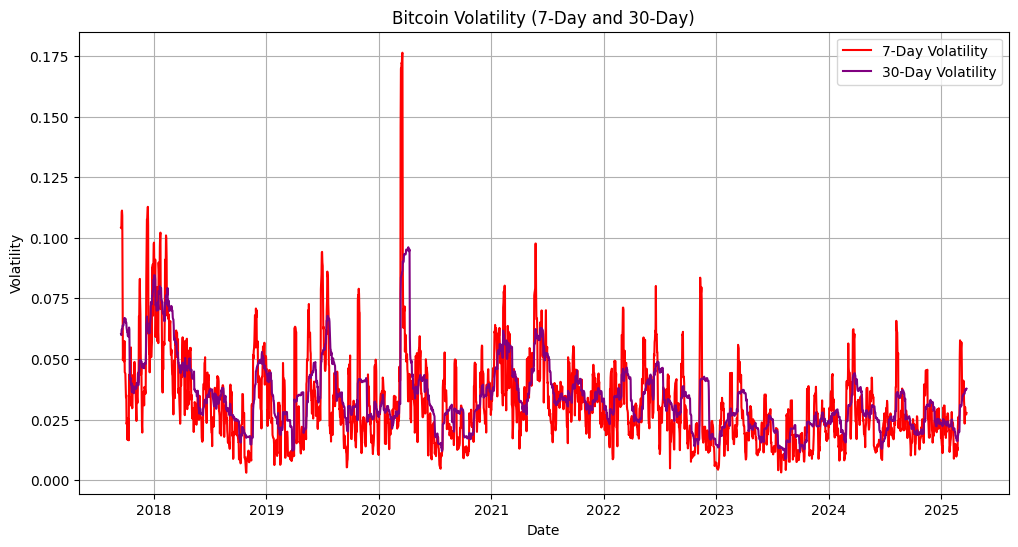

In [24]:

# Convert timestamp to datetime for better visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df['timestamp'], df['moving_avg_7'], label='7-Day Moving Average', color='orange')
plt.plot(df['timestamp'], df['moving_avg_30'], label='30-Day Moving Average', color='green')
plt.title('Bitcoin Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plot Volatility
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['volatility_7'], label='7-Day Volatility', color='red')
plt.plot(df['timestamp'], df['volatility_30'], label='30-Day Volatility', color='purple')
plt.title('Bitcoin Volatility (7-Day and 30-Day)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

### Stochastic Price Sim (GBM)

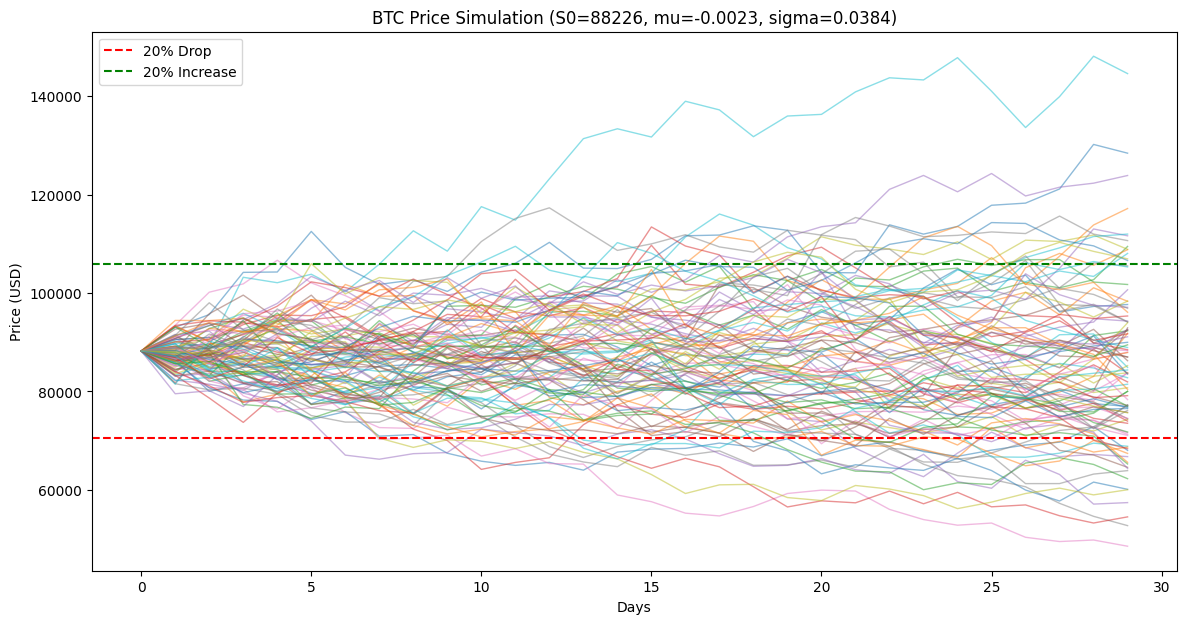

Probability of >20% drop in 30 days: 18.00%
Probability of >20% increase in 30 days: 13.00%


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_btc_prices(df):
    # Last 30 days for params
    recent = df.tail(30)
    S0 = recent['close'].iloc[-1]  # Latest price
    mu = recent['close'].pct_change().mean()  # Drift
    sigma = recent['close'].pct_change().std()  # Volatility

    # Simulation parameters
    T = 30  # 30 days forward
    n_paths = 100
    dt = 1

    # Simulate
    np.random.seed(42)
    prices = np.zeros((T, n_paths))
    prices[0] = S0

    for t in range(1, T):
        rand = np.random.normal(0, 1, n_paths)
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand)

    # Stats
    final_prices = prices[-1]
    drop_prob = np.mean(final_prices < S0 * 0.8) * 100  # Probability of >20% drop
    increase_prob = np.mean(final_prices > S0 * 1.2) * 100  # Probability of >20% increase

    # Plot
    plt.figure(figsize=(14, 7))
    for i in range(n_paths):
        plt.plot(prices[:, i], lw=1, alpha=0.5)
    plt.axhline(S0 * 0.8, color='r', linestyle='--', label='20% Drop')
    plt.axhline(S0 * 1.2, color='g', linestyle='--', label='20% Increase')
    plt.title(f"BTC Price Simulation (S0={S0:.0f}, mu={mu:.4f}, sigma={sigma:.4f})")
    plt.xlabel("Days")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

    print(f"Probability of >20% drop in 30 days: {drop_prob:.2f}%")
    print(f"Probability of >20% increase in 30 days: {increase_prob:.2f}%")
    return prices

# Run it
sim_prices = simulate_btc_prices(df)